# Goal
This notebook contains script that loads the SNP embeddings and train an autoencoder

In [25]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm
import scipy.sparse as sp

## Prepare the data

### Load and Convert the embedding to DataFrame

In [26]:
# Directories for input and output
output_dir = '../../Data/SSC_VEP_filtered'
image_output_dir = '../../Image'
os.makedirs(image_output_dir, exist_ok=True)

# Load the embeddings
embeddings_output_path = os.path.join(output_dir, 'individual_embeddings.npy')

embedding_matrix = pd.read_csv('../../Data/TF_Embeddings/tf_embeddings_batch_10.csv', index_col=0)

print(f'Embedding matrix shape: {embedding_matrix.shape}')
print(f'Embedding matrix type: {type(embedding_matrix)}')


embedding_matrix = embedding_matrix.loc[:,embedding_matrix.sum()>0]
print(f'Embedding matrix shape after removing zeros: {embedding_matrix.shape}')

TF_Cols = [True if 'ENS' in col else False for col in embedding_matrix.columns]
embedding_matrix = embedding_matrix.loc[:, TF_Cols]
print(f'Embedding matrix shape after removing zeros and enhancers: {embedding_matrix.shape}')

# Ensure the data type is float32 for the tensor conversion
embedding_matrix = embedding_matrix.astype(int)

# Check for any issues in the embedding matrix
if np.any(np.isnan(embedding_matrix)):
    raise ValueError("Embedding matrix contains NaN values")


Embedding matrix shape: (128, 50599)
Embedding matrix type: <class 'pandas.core.frame.DataFrame'>
Embedding matrix shape after removing zeros: (128, 38788)
Embedding matrix shape after removing zeros and enhancers: (128, 5803)


## Train the autoencoder

### Define the model

In [27]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

class LargeDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        batch = self.data.iloc[idx]
        batch_tensor = torch.tensor(batch.values, dtype=torch.float32)
        return batch_tensor, batch_tensor  # Returning the same tensor as input and target


# Create a dataset and dataloader
dataset = LargeDataset(embedding_matrix)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


Train the Autoencoder in Batches

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, code_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, code_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(code_dim, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, input_dim),
            nn.ReLU() 
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


In [29]:
# Set parameters
input_dim = embedding_matrix.shape[1]
hidden_dim1 = 1024
hidden_dim2 = 512
code_dim = 128  # Adjusted reduced dimension

# Initialize autoencoder
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
autoencoder = Autoencoder(input_dim, hidden_dim1, hidden_dim2, code_dim).to(device)

# Training settings
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
num_epochs = 50
batch_size = 32

# Custom dataset and dataloader
class LargeDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        batch = self.data.iloc[idx]
        batch_tensor = torch.tensor(batch.values, dtype=torch.float32)
        return batch_tensor, batch_tensor  # Returning the same tensor as input and target

dataset = LargeDataset(embedding_matrix)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training loop with overall progress bar
progress_bar = tqdm(total=num_epochs, desc='Training Autoencoder', unit='epoch')

for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_features, _ in dataloader:
        batch_features = batch_features.to(device)

        optimizer.zero_grad()
        encoded, decoded = autoencoder(batch_features)
        loss = criterion(decoded, batch_features)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    progress_bar.set_postfix({'loss': epoch_loss / len(dataloader)})
    progress_bar.update(1)
progress_bar.close()

# Extract the encoded features and calculate reconstruction error
autoencoder.eval()
encoded_embeddings = []
reconstruction_errors = []

with torch.no_grad():
    for batch_features, _ in dataloader:
        batch_features = batch_features.to(device)
        encoded, decoded = autoencoder(batch_features)
        encoded_embeddings.append(encoded.cpu().numpy())
        
        # Calculate reconstruction error for the batch
        batch_mse = F.mse_loss(decoded, batch_features, reduction='none').mean(dim=1)
        reconstruction_errors.append(batch_mse.cpu().numpy())

encoded_embeddings = np.vstack(encoded_embeddings)
reconstruction_errors = np.concatenate(reconstruction_errors)

# Calculate overall reconstruction accuracy
average_reconstruction_error = reconstruction_errors.mean()
print(f'Average Reconstruction Error (MSE): {average_reconstruction_error}')

# Print the shape of the encoded embeddings
print(f'Encoded embeddings shape: {encoded_embeddings.shape}')


Training Autoencoder:   0%|          | 0/50 [00:00<?, ?epoch/s]

Average Reconstruction Error (MSE): 0.1578156054019928
Encoded embeddings shape: (128, 128)


In [30]:
# Save the trained autoencoder model
autoencoder_path = 'autoencoder.pth'
torch.save(autoencoder.state_dict(), autoencoder_path)
print(f'Autoencoder model saved to {autoencoder_path}')


Autoencoder model saved to autoencoder.pth


In [31]:
import numpy as np

# Assuming encoded_embeddings is already computed
# Save the encoded embeddings to a file
encoded_embeddings_path = 'encoded_embeddings.npy'
np.save(encoded_embeddings_path, encoded_embeddings)
print(f'Encoded embeddings saved to {encoded_embeddings_path}')


Encoded embeddings saved to encoded_embeddings.npy


In [32]:
import pandas as pd

# Convert encoded embeddings to a DataFrame
encoded_embeddings_df = pd.DataFrame(encoded_embeddings, index=embedding_matrix.index)

# Save the DataFrame to a CSV file
encoded_embeddings_df.to_csv('encoded_embeddings.csv')
print('Encoded embeddings saved to encoded_embeddings.csv')


Encoded embeddings saved to encoded_embeddings.csv


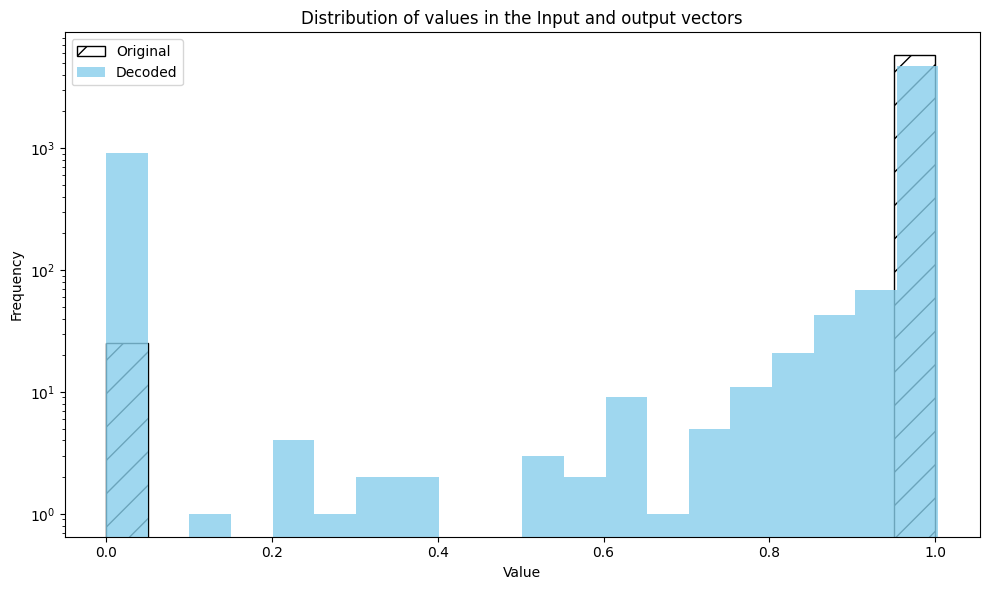

In [34]:
import matplotlib.pyplot as plt
i = 0

def plot_dist(i):
    foo = decoded[i].cpu()
    bar = batch_features[i].cpu()
    
    # Convert tensors to numpy arrays for plotting
    foo_np = foo.numpy()
    bar_np = bar.numpy()
    
    # Plot the histograms with different styles
    plt.figure(figsize=(10, 6))
    
    plt.hist(bar_np, bins=20, color='white', edgecolor='black', label='Original', hatch='/')
    plt.hist(foo_np, bins=20, color='skyblue', alpha=0.8, label='Decoded', hatch='')
    
    plt.title('Distribution of values in the Input and output vectors')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.yscale('log')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(image_output_dir, 'Distribution of values in the Input and output vectors.jpg'))
    plt.show()

plot_dist(i)


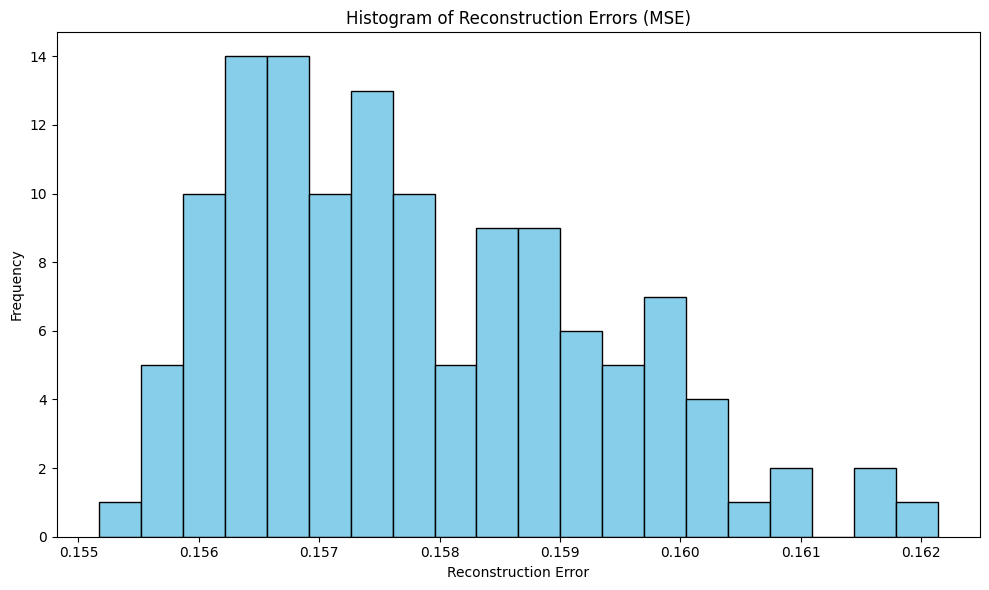

In [35]:
import matplotlib.pyplot as plt

# Plot the histogram of reconstruction errors
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_errors, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Reconstruction Errors (MSE)')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig(os.path.join(image_output_dir, 'reconstruction_error_histogram.png'))
plt.show()


In [36]:
encoded_embeddings_df = pd.read_csv('encoded_embeddings.csv', index_col=0)

In [37]:
id_map = pd.read_csv("../../Data/SSC_VEP_GZ/documentation/nygc_sfari_id_map.csv")
id_map['Role'] = id_map['SFARI ID'].apply(lambda x: x.split(".")[1])

In [38]:
id_map

,SFARI ID,Repository Id,Role
0,11000.fa,SSC02219,fa
1,11000.mo,SSC02217,mo
2,11000.p1,SSC02254,p1
3,11000.s1,SSC02220,s1
4,11001.fa,SSC02184,fa
...,...,...,...
9380,14698.s1,SSC12833,s1
9381,14699.fa,SSC12952,fa
9382,14699.mo,SSC12951,mo
9383,14699.p1,SSC12957,p1


In [39]:
encoded_embeddings_df.index = [x.replace('.bed',"") for x in encoded_embeddings_df.index]

In [40]:
# Merge the DataFrames based on the 'Repository Id' column
merged_df = pd.merge(id_map, encoded_embeddings_df, left_on='Repository Id', right_index=True)
merged_df['ASD'] = merged_df['Role'].apply(lambda x: 1 if x == 'p1' else 0)
merged_df

,SFARI ID,Repository Id,Role,0,1,2,3,4,5,6,...,119,120,121,122,123,124,125,126,127,ASD
38,11012.s1,SSC00838,s1,0.0,0.0,0.0,0.0,0.974124,0.827480,2.268756,...,0.0,1.476750,0.0,1.836992,0.0,0.0,0.0,0.0,0.496794,0
225,11080.p1,SSC03276,p1,0.0,0.0,0.0,0.0,0.968998,0.820391,2.246743,...,0.0,1.462792,0.0,1.821915,0.0,0.0,0.0,0.0,0.496674,1
270,11098.p1,SSC02197,p1,0.0,0.0,0.0,0.0,0.972149,0.826397,2.264066,...,0.0,1.472771,0.0,1.829459,0.0,0.0,0.0,0.0,0.495466,1
296,11110.fa,SSC04444,fa,0.0,0.0,0.0,0.0,0.975324,0.825100,2.268827,...,0.0,1.474863,0.0,1.838449,0.0,0.0,0.0,0.0,0.498294,0
308,11115.mo,SSC00811,mo,0.0,0.0,0.0,0.0,0.977084,0.828632,2.274212,...,0.0,1.479508,0.0,1.842054,0.0,0.0,0.0,0.0,0.499332,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8542,14452.fa,SSC11882,fa,0.0,0.0,0.0,0.0,0.974539,0.826744,2.263694,...,0.0,1.472379,0.0,1.831743,0.0,0.0,0.0,0.0,0.496905,0
8544,14452.p1,SSC11869,p1,0.0,0.0,0.0,0.0,0.975525,0.829604,2.268875,...,0.0,1.476440,0.0,1.834350,0.0,0.0,0.0,0.0,0.497803,1
8545,14452.s1,SSC11883,s1,0.0,0.0,0.0,0.0,0.975290,0.826964,2.267795,...,0.0,1.476671,0.0,1.837280,0.0,0.0,0.0,0.0,0.498352,0
9132,14622.mo,SSC12622,mo,0.0,0.0,0.0,0.0,0.973815,0.828138,2.269716,...,0.0,1.478500,0.0,1.835560,0.0,0.0,0.0,0.0,0.496593,0


In [41]:
import numpy as np

# Assume merged_df is already defined and contains the required data

# Define columns to exclude (identifiers and labels)
exclude_columns = ['SFARI ID', 'Repository Id', 'Fam', 'Role', 'ASD']

# Extract feature columns by excluding the specified columns
feature_columns = [col for col in merged_df.columns if col not in exclude_columns]

# Extract X and y from merged_df
X = merged_df[feature_columns].values
y = merged_df['ASD'].values

print(f'Feature matrix shape: {X.shape}')
print(f'Labels shape: {y.shape}')


Feature matrix shape: (128, 128)
Labels shape: (128,)


### test tain split

In [42]:
from sklearn.model_selection import train_test_split

# Split the encoded features and labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')


X_train shape: (102, 128), X_test shape: (26, 128)


### compute class weights

In [43]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print(f'Class weights: {class_weight_dict}')


Class weights: {0: 0.7183098591549296, 1: 1.6451612903225807}


### train

In [44]:
from sklearn.linear_model import LogisticRegression

# Train a Logistic Regression classifier with class weights
classifier = LogisticRegression(max_iter=1000, random_state=42, class_weight=class_weight_dict)
classifier.fit(X_train, y_train)


LogisticRegression(class_weight={0: 0.7183098591549296, 1: 1.6451612903225807},
                   max_iter=1000, random_state=42)

### evaluate

In [45]:
from sklearn.metrics import accuracy_score, classification_report

# Predict on the test set
y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'], zero_division=1)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)


Accuracy: 0.5384615384615384
Classification Report:
              precision    recall  f1-score   support

    Negative       0.69      0.61      0.65        18
    Positive       0.30      0.38      0.33         8

    accuracy                           0.54        26
   macro avg       0.49      0.49      0.49        26
weighted avg       0.57      0.54      0.55        26



### Neural Network

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Define a custom Dataset class for large datasets
class LargeDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Convert only a single data point to tensor at a time
        X_tensor = torch.tensor(self.X[idx], dtype=torch.float32)
        y_tensor = torch.tensor(self.y[idx], dtype=torch.long)
        return X_tensor, y_tensor

# Define DataLoader for batch processing
batch_size = 32
train_dataset = LargeDataset(X_train, y_train)
test_dataset = LargeDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Define a simple neural network model in PyTorch
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model
input_size = X_train.shape[1]  # Number of features
num_classes = len(np.unique(y_train))
model = SimpleNN(input_size, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Evaluate the model on the test set
model.eval()
y_pred_list = []
y_test_list = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, y_pred = torch.max(outputs, 1)
        y_pred_list.append(y_pred)
        y_test_list.append(y_batch)

# Flatten the list of predictions and actuals
y_pred = torch.cat(y_pred_list).numpy()
y_test = torch.cat(y_test_list).numpy()

# Calculate accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'], zero_division=1)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)


### Visualization on 2D

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Predict on the test set
y_pred = classifier.predict(X_train)

# Perform t-SNE to reduce X to 2D
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train)
print(f't-SNE result shape: {X_tsne.shape}')



# Plot t-SNE projection colored by true labels
plt.figure(figsize=(12, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_train, palette='viridis', s=100)
plt.title('t-SNE Projection Colored by True Labels')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='True Labels')
plt.tight_layout()
plt.show()

# Plot t-SNE projection colored by prediction results
plt.figure(figsize=(12, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_pred, palette='coolwarm', s=100)
plt.title('t-SNE Projection Colored by Prediction Results')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Prediction Results')
plt.tight_layout()
plt.show()


In [ ]:
combined_labels[combined_labels == 'FP']

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Predict on the test set
y_pred = classifier.predict(X_train)

# Create a combined label array initialized with empty strings, using dtype=object to prevent truncation
combined_labels = np.array([''] * len(y_train), dtype=object)

# Assign the correct label for each case
combined_labels[(y_train == 1) & (y_pred == 1)] = 'TP'  # True Positive
combined_labels[(y_train == 0) & (y_pred == 0)] = 'TN'  # True Negative
combined_labels[(y_train == 0) & (y_pred == 1)] = 'FP'  # False Positive
combined_labels[(y_train == 1) & (y_pred == 0)] = 'FN'  # False Negative

# Perform t-SNE to reduce X to 2D
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train)
print(f't-SNE result shape: {X_tsne.shape}')

# Define a new color palette for each category
palette = {
    'TP': '#2ECC71',  # Soft green for True Positive
    'TN': '#3498DB',  # Soft blue for True Negative
    'FP': '#E74C3C',  # Soft red for False Positive
    'FN': '#F1C40F'   # Soft yellow for False Negative
}

# Plot t-SNE projection with combined labels
plt.figure(figsize=(12, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=combined_labels, palette=palette, s=100)
plt.title('t-SNE Projection Colored by Prediction Categories (TP, TN, FP, FN) ON TRAINING SET')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Prediction Category')
plt.tight_layout()
plt.savefig(os.path.join(image_output_dir, 't-SNE Projection Colored by Prediction Categories (TP, TN, FP, FN) ON TRAINING SET.jpg'))
plt.show()


In [ ]:
y_train.shape

In [18]:
y_pred.shape

NameError: name 'y_pred' is not defined

### Simple NN

In [190]:
import numpy as np

# Assume merged_df is already defined and contains the required data

# Define columns to exclude (identifiers and labels)
exclude_columns = ['SFARI ID', 'Fam', 'Role', 'ASD']

# Extract feature columns by excluding the specified columns
feature_columns = [col for col in merged_df.columns if col not in exclude_columns]

# Extract X and y from merged_df
X = merged_df[feature_columns].values
y = merged_df['ASD'].values

print(f'Feature matrix shape: {X.shape}')
print(f'Labels shape: {y.shape}')


from sklearn.model_selection import train_test_split

# Assuming encoded_X and y are already prepared
X_train, X_test, y_train, y_test = train_test_split(encoded_X, y, test_size=0.2, random_state=42)
print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')


Feature matrix shape: (1210, 5730)
Labels shape: (1210,)


ValueError: Found input variables with inconsistent numbers of samples: [0, 1210]

In [200]:
# Split the encoded features and labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(encoded_X, y, test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")  # Should be (968, 64) and (242, 64)

X_train shape: (968, 64), X_test shape: (242, 64)


In [197]:
X_train.shape

(968, 64)

In [201]:
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim):
        super(FeedforwardNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Sigmoid for binary classification
        )

    def forward(self, x):
        return self.layers(x)


In [202]:
# Custom dataset and dataloader for classification
class ClassificationDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)

# Create dataset and dataloader for training and test sets
train_dataset = ClassificationDataset(X_train, y_train)
test_dataset = ClassificationDataset(X_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [203]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Define weighted BCE loss
class WeightedBCELoss(nn.Module):
    def __init__(self, weights):
        super(WeightedBCELoss, self).__init__()
        self.weights = weights

    def forward(self, inputs, targets):
        loss = self.weights[1] * targets * torch.log(inputs) + self.weights[0] * (1 - targets) * torch.log(1 - inputs)
        return -loss.mean()

# Initialize the model, weighted loss function, and optimizer
model = FeedforwardNN(input_dim=64).to(device)  # Ensure input_dim is 64
criterion = WeightedBCELoss(class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
progress_bar = tqdm(total=num_epochs, desc='Training Neural Network', unit='epoch')

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    for batch_data, batch_labels in train_dataloader:
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        outputs = model(batch_data).squeeze()
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    progress_bar.set_postfix({'loss': epoch_loss / len(train_dataloader)})
    progress_bar.update(1)
progress_bar.close()


Training Neural Network:   0%|          | 0/50 [00:00<?, ?epoch/s]

In [204]:
# Evaluate the model
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_data, batch_labels in test_dataloader:
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
        outputs = model(batch_data).squeeze()
        preds = (outputs > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

# Calculate accuracy and print classification report
accuracy = accuracy_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=['Negative', 'Positive'], zero_division=1)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)


Accuracy: 0.40082644628099173
Classification Report:
              precision    recall  f1-score   support

    Negative       0.63      0.37      0.47       171
    Positive       0.24      0.46      0.31        71

    accuracy                           0.40       242
   macro avg       0.43      0.42      0.39       242
weighted avg       0.51      0.40      0.42       242



# TF + Enhancer

In [2]:
import os
import numpy as np
import pandas as pd

# Directories for input and output
output_dir = '../../Data/SSC_VEP_filtered'

# Load the TF embeddings
tf_embedding_matrix = pd.read_csv('../../Data/TF_Embeddings/tf_embeddings_batch_10.csv', index_col=0)

# Process TF Embeddings (already done in your existing code)
TF_Cols = [True if 'ENS' in col else False for col in tf_embedding_matrix.columns]
tf_embedding_matrix = tf_embedding_matrix.loc[:, TF_Cols]
tf_embedding_matrix = tf_embedding_matrix.astype(int)

# Load the Enhancer embeddings
enhancer_embedding_matrix = pd.read_csv('../../Data/Enhancer_Embeddings/enhancer_embeddings_batch_10.csv', index_col=0)

# Process Enhancer Embeddings (remove non-enhancer columns, i.e., those not starting with 'E')
enhancer_embedding_matrix = enhancer_embedding_matrix.loc[:, [col for col in enhancer_embedding_matrix.columns if col.startswith('E')]]
enhancer_embedding_matrix = enhancer_embedding_matrix.astype(int)

# Merge the two matrices with an OR gate (element-wise maximum)
merged_embeddings = np.maximum(tf_embedding_matrix.values, enhancer_embedding_matrix.values)


# Convert back to DataFrame for easier manipulation and saving
merged_embeddings_df = pd.DataFrame(merged_embeddings, index=tf_embedding_matrix.index, columns=tf_embedding_matrix.columns)

merged_embeddings_df = merged_embeddings_df.loc[:, merged_embeddings_df.sum() > 0]

# Save the merged embeddings
output_merged_file = os.path.join(output_dir, 'merged_tf_enhancer_embeddings.csv')
merged_embeddings_df.to_csv(output_merged_file)

print(f'Merged embeddings shape: {merged_embeddings_df.shape}')
print(f'Merged embeddings saved to: {output_merged_file}')


Merged embeddings shape: (1280, 5803)
Merged embeddings saved to: ../../Data/SSC_VEP_filtered/merged_tf_enhancer_embeddings.csv


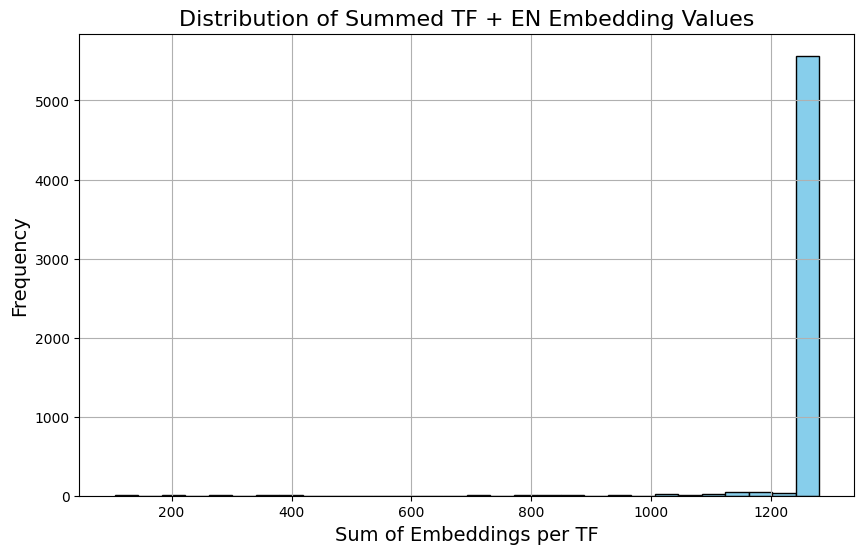

In [19]:
import matplotlib.pyplot as plt

# Plot the histogram of the sum of the embeddings
plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(merged_embeddings_df.sum(), bins=30, color='skyblue', edgecolor='black')  # Adjust the number of bins and color

# Add a title and axis labels
plt.title('Distribution of Summed TF + EN Embedding Values', fontsize=16)
plt.xlabel('Sum of Embeddings per TF', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Add a grid for better readability
plt.grid(True)

plt.savefig("../../Image/TF_EN_emb_col_sum_hist.png")
# Show the plot
plt.show()


In [20]:
tf_embeddings_df = pd.DataFrame(tf_embedding_matrix)

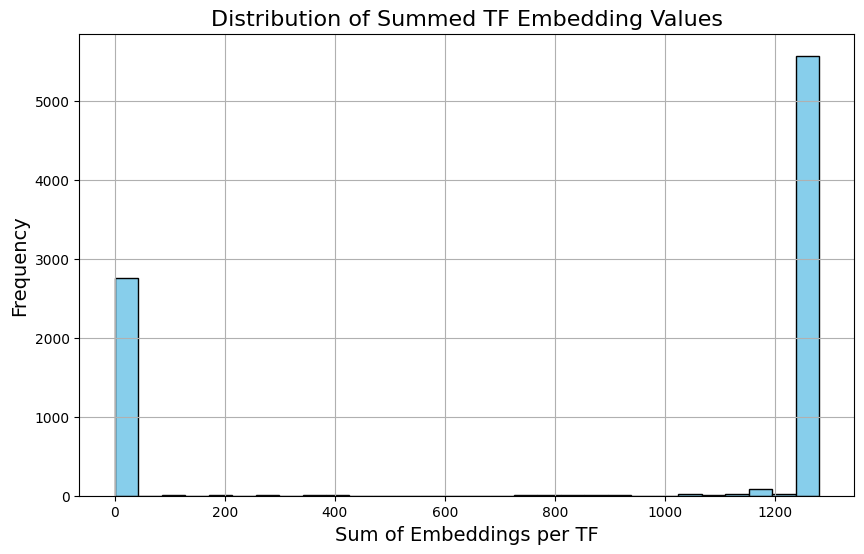

In [23]:
import matplotlib.pyplot as plt

# Plot the histogram of the sum of the embeddings
plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(tf_embeddings_df.sum(), bins=30, color='skyblue', edgecolor='black')  # Adjust the number of bins and color

# Add a title and axis labels
plt.title('Distribution of Summed TF Embedding Values', fontsize=16)
plt.xlabel('Sum of Embeddings per TF', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Add a grid for better readability
plt.grid(True)

plt.savefig("../../Image/TF_emb_col_sum_hist.png")
# Show the plot
plt.show()


In [24]:
merged_embeddings_df

,ENSG00000228794.10,ENSG00000223764.2,ENSG00000187634.12,ENSG00000188976.11,ENSG00000187961.14,ENSG00000188157.15,ENSG00000131591.17,ENSG00000078808.17,ENSG00000184163.3,ENSG00000260179.1,...,ENSG00000169057.23,ENSG00000007350.17,ENSG00000196924.18,ENSG00000285018.1,ENSG00000013563.14,ENSG00000102125.16,ENSG00000126903.16,ENSG00000071889.16,ENSG00000160211.19,ENSG00000269335.5
SSC08026.bed,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
SSC07315.bed,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
SSC08740.bed,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
SSC08754.bed,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
SSC07467.bed,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SSC09149.bed,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
SSC07164.bed,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
SSC07602.bed,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
SSC05001.bed,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
